## LSTM on only reviews for predicting usefulness

In [0]:
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.datasets import imdb
import json
from pandas.io.json import json_normalize
from collections import Counter
import copy
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
import nltk
import tensorflow as tf
from sklearn.metrics import roc_auc_score,roc_curve

#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nlp = spacy.load('en')
from sklearn.model_selection import train_test_split
import pickle

from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors

In [2]:
from google.colab import drive
drive.mount('/content/drive')  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
reviews_data_train = pd.read_csv('/content/drive/My Drive/Task2_Search/TrainTestFiles/reviews_data_train.csv')
reviews_data_test = pd.read_csv('/content/drive/My Drive/Task2_Search/TrainTestFiles/reviews_data_test.csv')

In [6]:
reviews_data_train.head()

,review_id,cleaned_text_final,user_rating_of_business,class_useful,business_review_count,business_rating,category_vector,Restaurants,Food,American (Traditional),Nightlife,Bars,Sandwiches,Fast Food,American (New),Pizza,Mexican,Burgers,Breakfast & Brunch,Italian,Chinese,Coffee & Tea,Salad,Event Planning & Services,Chicken Wings,Seafood,Sports Bars,Delis,Cafes,Japanese,Caterers,Steakhouses,Sushi Bars,Bakeries,Asian Fusion,Barbeque,Specialty Food,Desserts,Diners,Beer,...,Food Trucks,Korean,Music Venues,Gastropubs,Local Flavor,Chicken Shop,French,Hotels,Tapas/Small Plates,Beer Bar,Hawaiian,Active Life,Soul Food,Dive Bars,Noodles,Donuts,Food Stands,Breweries,Cajun/Creole,Casinos,Cheesesteaks,Caribbean,Tapas Bars,Karaoke,Street Vendors,Pakistani,Halal,Irish,Tacos,Dance Clubs,Fish & Chips,Filipino,Party & Event Planning,Spanish,Meat Shops,Convenience Stores,average_stars,user_review_count,useful_votes_user,fans
0,N2gp3mfhdO9f24X8asEtdA,order pork grinder favorite bone chunks fat gu...,1.0,0,630,4.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.00,2,1,0
1,HOuf_liDHJ97Kx1HnDbJ-Q,Every walk restaurant immediately feel home Yo...,4.0,0,253,4.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.94,33,33,0
2,mizfLpOErvLapK21q-w4nA,Great food Waiter awesome great view fountains...,5.0,0,1783,4.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.70,20,16,0
3,2jURlxgOi7ToO_rdvVrYKg,Every drink That selling point Pei Wei airport...,3.0,1,264,2.5,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.53,1886,5868,197
4,I2A9KstZYQfGfFbECTk_hw,OK avoid toro rough flavor tasted little like ...,4.0,1,263,3.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.80,353,637,30


Train validation split

In [0]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(reviews_data_train,test_size=0.2, random_state=42)

In [0]:


reviews_data_x_train = train["cleaned_text_final"]
reviews_data_y_train = train["class_useful"]
reviews_data_x_val = val["cleaned_text_final"]
reviews_data_y_val = val["class_useful"]
reviews_data_x_test = reviews_data_test["cleaned_text_final"]
reviews_data_y_test = reviews_data_test["class_useful"]




In [0]:
reviews_data_x_train = reviews_data_x_train.reset_index().drop(["index"],axis=1)
reviews_data_x_val = reviews_data_x_val.reset_index().drop(["index"],axis=1)
reviews_data_y_train = reviews_data_y_train.reset_index().drop(["index"],axis=1)
reviews_data_y_val = reviews_data_y_val.reset_index().drop(["index"],axis=1)

Using glove for Word Embedding (Reference: https://www.kaggle.com/thousandvoices/simple-lstm)

In [0]:
def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix

In [0]:
DENSE_HIDDEN_UNITS1 = 512
DENSE_HIDDEN_UNITS2 = 512
DENSE_HIDDEN_UNITS3 = 512
LSTM_UNITS1 = 256
LSTM_UNITS2 = 256

def auc(y_true, y_pred):
        auc = tf.metrics.auc(y_true, y_pred)[1]
        K.get_session().run(tf.local_variables_initializer())
        return auc

def build_model(embedding_matrix):
    
    words = Input(shape=(None,))

    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    #print(x.shape)
    drop1 = SpatialDropout1D(0.4)(x)
    lstm1 = Bidirectional(CuDNNLSTM(LSTM_UNITS1, return_sequences=True))(drop1)
    drop2 = Dropout(0.5)(lstm1)
    lstm2 = Bidirectional(CuDNNLSTM(LSTM_UNITS2, return_sequences=True))(drop2)
    #print(lstm2.shape)
    hidden = concatenate([
        GlobalMaxPooling1D()(lstm2),
        GlobalAveragePooling1D()(lstm2),
    ])
    
    dense1 = Dense(DENSE_HIDDEN_UNITS1, activation='relu')(hidden)
    drop3 = Dropout(0.5)(dense1)

    result1 = Dense(1, activation='sigmoid')(drop3)  

    model = Model(inputs=words, outputs=result1)
    model.compile(loss=binary_crossentropy, optimizer=Adam(lr = 0.001),metrics = ['accuracy',auc])

    return model

In [0]:
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

MAX_LEN = 220
EMBEDDING_FILES = [
    '/content/drive/My Drive/Task2_Search/crawl-300d-2M.gensim',
    '/content/drive/My Drive/Task2_Search/glove.840B.300d.gensim'
]

x_train = reviews_data_x_train["cleaned_text_final"].astype(str)
y_train = reviews_data_y_train.values
x_test = reviews_data_x_test.astype(str)
y_test = reviews_data_y_test.values
x_val = reviews_data_x_val["cleaned_text_final"].astype(str)
y_val = reviews_data_y_val.values

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test) +  list(x_val))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(x_val)

x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)
x_val = sequence.pad_sequences(x_val, maxlen=MAX_LEN)

In [14]:
print(x_train.shape)

(214211, 220)


In [15]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
model = build_model(embedding_matrix)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [17]:
model = build_model(embedding_matrix)
model.fit(x_train, y_train, batch_size = 100, epochs = 5, validation_data = (x_val, y_val))



Train on 214211 samples, validate on 53553 samples
Epoch 1/5
214211/214211 [==============================] - 368s 2ms/step - loss: 0.6424 - acc: 0.6337 - auc: 0.6726 - val_loss: 0.6387 - val_acc: 0.6375 - val_auc: 0.6801
Epoch 2/5
214211/214211 [==============================] - 361s 2ms/step - loss: 0.6359 - acc: 0.6401 - auc: 0.6825 - val_loss: 0.6360 - val_acc: 0.6382 - val_auc: 0.6848
Epoch 3/5
214211/214211 [==============================] - 358s 2ms/step - loss: 0.6327 - acc: 0.6441 - auc: 0.6866 - val_loss: 0.6369 - val_acc: 0.6379 - val_auc: 0.6877
Epoch 4/5
214211/214211 [==============================] - 357s 2ms/step - loss: 0.6295 - acc: 0.6470 - auc: 0.6890 - val_loss: 0.6353 - val_acc: 0.6415 - val_auc: 0.6902
Epoch 5/5
214211/214211 [==============================] - 360s 2ms/step - loss: 0.6252 - acc: 0.6515 - auc: 0.6917 - val_loss: 0.6346 - val_acc: 0.6391 - val_auc: 0.6927


In [18]:
y_pred = model.predict(x_test)
print("AUC Score:", roc_auc_score(y_test, y_pred))


AUC Score: 0.6967128940946751


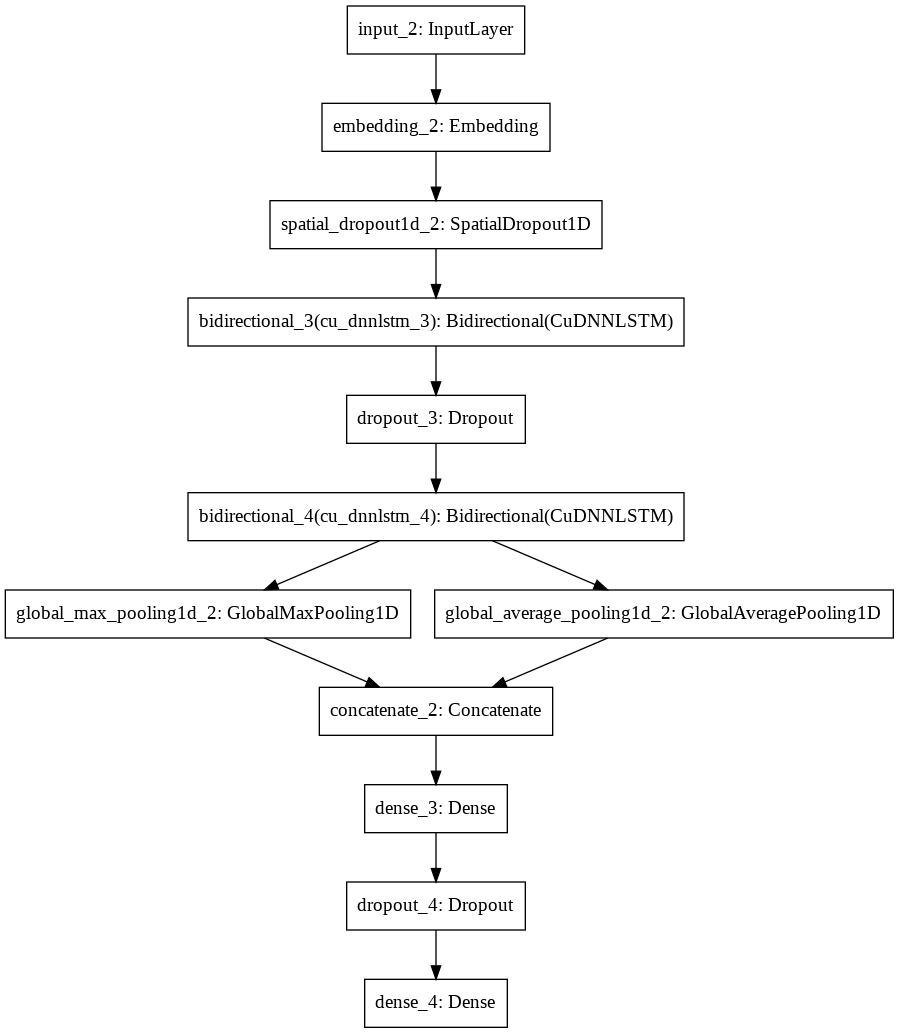

In [19]:
plot_model(model, to_file='/content/drive/My Drive/Task2_Search/Saved_Models/Architecture_Model1_Reviews.png')

Model 2: ROC AUC=0.697


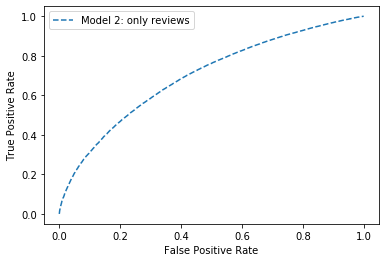

In [26]:


res_auc = roc_auc_score(y_test, y_pred)
print('Model 2: ROC AUC=%.3f' % (res_auc))

rs_fpr, rs_tpr, _ = roc_curve(y_test, y_pred)

plt.plot(rs_fpr, rs_tpr, linestyle='--', label='Model 2: only reviews')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()